In [1]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
from datetime import datetime
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statistics import mean

In [2]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")[2].rename(columns={"Symbol":"ticker"})

In [3]:
def calculate_technical_indicators(price):
    # Average Return
    price["average_return"] = price["adjclose"].pct_change(5).rolling(100).mean()
    price["prev_return"] = price["adjclose"].pct_change(5)
    
    # Coefficient of Variation
    price["coev"] = price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean()
    price["return_to_risk"] = price["prev_return"] / price["coev"]
    
    # Bollinger Bands
    price["bollinger"] = ((price["adjclose"].rolling(100).mean() - 2 * price["adjclose"].rolling(100).std()) - price["adjclose"]) / price["adjclose"]

    # RSI (Relative Strength Index)
    delta = price["adjclose"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    price["rsi"] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    ema_12 = price["adjclose"].ewm(span=12, adjust=False).mean()
    ema_26 = price["adjclose"].ewm(span=26, adjust=False).mean()
    price["macd"] = ema_12 - ema_26
    price["signal_line"] = price["macd"].ewm(span=9, adjust=False).mean()

    # EMA (Exponential Moving Average)
    price["ema_20"] = price["adjclose"].ewm(span=20, adjust=False).mean()

    # ATR (Average True Range)
    high_low = price["adjhigh"] - price["adjlow"]
    high_close = np.abs(price["adjhigh"] - price["adjclose"].shift())
    low_close = np.abs(price["adjlow"] - price["adjclose"].shift())
    tr = high_low.combine(high_close, np.maximum).combine(low_close, np.maximum)
    price["atr"] = tr.rolling(14).mean()

    # Stochastic Oscillator
    low_14 = price["adjlow"].rolling(window=14).min()
    high_14 = price["adjhigh"].rolling(window=14).max()
    price["stochastic"] = (price["adjclose"] - low_14) / (high_14 - low_14) * 100

    # On-Balance Volume (OBV)
    price["obv"] = (np.sign(price["adjclose"].diff()) * price["volume"]).fillna(0).cumsum()

    # Chaikin Money Flow (CMF)
    money_flow_multiplier = ((price["adjclose"] - price["adjlow"]) - (price["adjhigh"] - price["adjclose"])) / (price["adjhigh"] - price["adjlow"])
    money_flow_volume = money_flow_multiplier * price["volume"]
    price["cmf"] = money_flow_volume.rolling(window=20).sum() / price["volume"].rolling(window=20).sum()

    # Williams %R
    price["williams_r"] = (price["adjhigh"].rolling(14).max() - price["adjclose"]) / (price["adjhigh"].rolling(14).max() - price["adjlow"].rolling(14).min()) * -100

    # Commodity Channel Index (CCI)
    typical_price = (price["adjhigh"] + price["adjlow"] + price["adjclose"]) / 3
    price["cci"] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # Ichimoku Cloud
    price["tenkan_sen"] = (price["adjhigh"].rolling(9).max() + price["adjlow"].rolling(9).min()) / 2
    price["kijun_sen"] = (price["adjhigh"].rolling(26).max() + price["adjlow"].rolling(26).min()) / 2
    price["senkou_span_a"] = (price["tenkan_sen"] + price["kijun_sen"]) / 2
    price["senkou_span_b"] = (price["adjhigh"].rolling(52).max() + price["adjlow"].rolling(52).min()) / 2
    
    # Force Index
    price["force_index"] = price["adjclose"].diff() * price["volume"]
    
    # Elder's Impulse System
    price["elder_impulse"] = np.where((price["adjclose"] > price["adjclose"].shift()) & (price["volume"] > price["volume"].shift()), 1, 0)
    
    # Keltner Channel
    price["keltner_upper"] = price["adjclose"].rolling(20).mean() + 2 * price["adjclose"].rolling(20).std()
    price["keltner_lower"] = price["adjclose"].rolling(20).mean() - 2 * price["adjclose"].rolling(20).std()
    
    return price


In [4]:
prices_data = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker})).sort_values("date")
        price = calculate_technical_indicators(price)
        prices_data.append(price.dropna())
    except Exception as e:
        print(ticker, str(e))
        continue
market.disconnect()

  0%|▍                                                                                                                                                                                                                                       | 2/1009 [00:00<01:06, 15.12it/s]

TXG 'date'


  1%|█▍                                                                                                                                                                                                                                      | 6/1009 [00:00<01:20, 12.49it/s]

AAON 'date'


  1%|█▊                                                                                                                                                                                                                                      | 8/1009 [00:00<01:12, 13.75it/s]

ACHC 'date'
AYI 'date'


  1%|███▏                                                                                                                                                                                                                                   | 14/1009 [00:00<00:49, 20.11it/s]

ADT 'date'
AAP 'date'
WMS 'date'
ACM 'date'


  2%|████▌                                                                                                                                                                                                                                  | 20/1009 [00:01<00:45, 21.97it/s]

AMG 'date'
AFRM 'date'
AGCO 'date'


  3%|█████▉                                                                                                                                                                                                                                 | 26/1009 [00:01<00:46, 21.04it/s]

ADC 'date'
AGNC 'date'
AL 'date'


  3%|██████▋                                                                                                                                                                                                                                | 29/1009 [00:01<00:57, 16.95it/s]

ALK 'date'
ACI 'date'
AA 'date'


  4%|████████▏                                                                                                                                                                                                                              | 36/1009 [00:02<01:02, 15.59it/s]

ALGM 'date'
ALSN 'date'


  4%|█████████▍                                                                                                                                                                                                                             | 41/1009 [00:02<00:55, 17.49it/s]

ALLY 'date'
ALNY 'date'


  5%|███████████▏                                                                                                                                                                                                                           | 49/1009 [00:02<00:52, 18.29it/s]

DOX 'date'
AMED 'date'
AS 'date'


  5%|████████████▌                                                                                                                                                                                                                          | 55/1009 [00:03<01:05, 14.65it/s]

AFG 'date'
AMH 'date'


  6%|█████████████▌                                                                                                                                                                                                                         | 59/1009 [00:03<01:11, 13.21it/s]

COLD 'date'


  6%|██████████████▍                                                                                                                                                                                                                        | 63/1009 [00:04<01:18, 12.02it/s]

AMKR 'date'


  7%|███████████████▎                                                                                                                                                                                                                       | 67/1009 [00:04<01:09, 13.51it/s]

NLY 'date'
AM 'date'
AR 'date'


  7%|█████████████████▏                                                                                                                                                                                                                     | 75/1009 [00:04<00:49, 18.90it/s]

APG 'date'
APLS 'date'
APO 'date'
APPF 'date'


  8%|█████████████████▋                                                                                                                                                                                                                     | 77/1009 [00:04<00:52, 17.89it/s]

APP 'date'
ATR 'date'
ARMK 'date'


  9%|███████████████████▉                                                                                                                                                                                                                   | 87/1009 [00:05<00:50, 18.16it/s]

ARES 'date'
AWI 'date'
ARW 'date'


  9%|████████████████████▌                                                                                                                                                                                                                  | 90/1009 [00:05<00:47, 19.42it/s]

ASH 'date'
AZPN 'date'
AGO 'date'
ALAB 'date'


 10%|█████████████████████▉                                                                                                                                                                                                                 | 96/1009 [00:05<00:43, 21.07it/s]

ATI 'date'
TEAM 'date'


 10%|██████████████████████▋                                                                                                                                                                                                                | 99/1009 [00:06<00:53, 17.01it/s]

AN 'date'


 10%|███████████████████████▋                                                                                                                                                                                                              | 104/1009 [00:06<00:58, 15.55it/s]

AGR 'date'
AVTR 'date'
CAR 'date'
AVT 'date'
AXTA 'date'
AXS 'date'


 11%|████████████████████████▊                                                                                                                                                                                                             | 109/1009 [00:06<00:43, 20.86it/s]

AZEK 'date'
AZTA 'date'


 11%|██████████████████████████▍                                                                                                                                                                                                           | 116/1009 [00:07<00:55, 16.22it/s]

OZK 'date'


 12%|████████████████████████████                                                                                                                                                                                                          | 123/1009 [00:07<00:48, 18.14it/s]

BRBR 'date'
BSY 'date'
BRK.B 'date'
BERY 'date'
BILL 'date'


 13%|█████████████████████████████▊                                                                                                                                                                                                        | 131/1009 [00:08<00:51, 17.06it/s]

BMRN 'date'
BIRK 'date'
BJ 'date'


 13%|███████████████████████████████                                                                                                                                                                                                       | 136/1009 [00:08<00:46, 18.62it/s]

HRB 'date'
SQ 'date'
OWL 'date'


 14%|███████████████████████████████▉                                                                                                                                                                                                      | 140/1009 [00:08<00:51, 16.97it/s]

BOKF 'date'
BAH 'date'


 14%|████████████████████████████████▊                                                                                                                                                                                                     | 144/1009 [00:08<00:53, 16.15it/s]

SAM 'date'
BYD 'date'
BFAM 'date'
BHF 'date'


 15%|█████████████████████████████████▉                                                                                                                                                                                                    | 149/1009 [00:09<00:46, 18.41it/s]

BRX 'date'


 15%|██████████████████████████████████▉                                                                                                                                                                                                   | 153/1009 [00:09<00:50, 17.12it/s]

BEPC 'date'
BF.A 'date'
BF.B 'date'
BRKR 'date'
BC 'date'


 16%|████████████████████████████████████▍                                                                                                                                                                                                 | 160/1009 [00:09<00:38, 21.86it/s]

BURL 'date'
BWXT 'date'


 16%|█████████████████████████████████████▌                                                                                                                                                                                                | 165/1009 [00:10<00:57, 14.63it/s]

CACI 'date'


 17%|██████████████████████████████████████▉                                                                                                                                                                                               | 171/1009 [00:10<01:02, 13.32it/s]

CPRI 'date'
CSL 'date'
CG 'date'


 18%|█████████████████████████████████████████                                                                                                                                                                                             | 180/1009 [00:11<00:48, 17.20it/s]

CRI 'date'
CVNA 'date'
CASY 'date'


 18%|█████████████████████████████████████████▍                                                                                                                                                                                            | 182/1009 [00:11<00:46, 17.76it/s]

CAVA 'date'


 18%|██████████████████████████████████████████▍                                                                                                                                                                                           | 186/1009 [00:11<00:57, 14.22it/s]

CCCS 'date'


 19%|██████████████████████████████████████████▊                                                                                                                                                                                           | 188/1009 [00:11<00:56, 14.43it/s]

CELH 'date'


 19%|███████████████████████████████████████████▊                                                                                                                                                                                          | 192/1009 [00:11<01:05, 12.49it/s]

CERT 'date'


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                        | 199/1009 [00:12<00:45, 17.71it/s]

CHE 'date'
CC 'date'
LNG 'date'
CHK 'date'


 20%|██████████████████████████████████████████████▌                                                                                                                                                                                       | 204/1009 [00:12<00:51, 15.59it/s]

CHH 'date'
CHRD 'date'


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                      | 208/1009 [00:12<00:52, 15.24it/s]

CHDN 'date'
CIEN 'date'


 21%|████████████████████████████████████████████████▎                                                                                                                                                                                     | 212/1009 [00:13<01:02, 12.71it/s]

CRUS 'date'


 22%|██████████████████████████████████████████████████▍                                                                                                                                                                                   | 221/1009 [00:13<00:36, 21.68it/s]

CIVI 'date'
CLVT 'date'
CLH 'date'
CWEN.A 'date'
CWEN 'date'
CLF 'date'
NET 'date'


 22%|███████████████████████████████████████████████████▋                                                                                                                                                                                  | 227/1009 [00:14<00:41, 18.95it/s]

CNA 'date'
CNH 'date'
COKE 'date'
CGNX 'date'


 23%|█████████████████████████████████████████████████████                                                                                                                                                                                 | 233/1009 [00:14<00:37, 20.77it/s]

COHR 'date'
COIN 'date'
COLB 'date'
COLM 'date'


 24%|██████████████████████████████████████████████████████▋                                                                                                                                                                               | 240/1009 [00:14<00:32, 23.99it/s]

CMA 'date'
FIX 'date'
CBSH 'date'
CNXC 'date'
CFLT 'date'


 25%|████████████████████████████████████████████████████████▊                                                                                                                                                                             | 249/1009 [00:15<00:50, 15.13it/s]

CNM 'date'


 26%|████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 265/1009 [00:16<00:32, 22.93it/s]

COTY 'date'
CPNG 'date'
CUZ 'date'
CR 'date'
CXT 'date'
CACC 'date'
CRH 'date'
CROX 'date'
CCK 'date'


 27%|█████████████████████████████████████████████████████████████                                                                                                                                                                         | 268/1009 [00:16<00:32, 22.94it/s]

CUBE 'date'
CW 'date'


 27%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 277/1009 [00:17<00:53, 13.73it/s]

DAR 'date'
DDOG 'date'


 28%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 284/1009 [00:17<00:52, 13.90it/s]

DELL 'date'
XRAY 'date'


 29%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 288/1009 [00:18<00:54, 13.21it/s]

DKS 'date'
DDS 'date'


 29%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 293/1009 [00:18<00:40, 17.47it/s]

DOCU 'date'
DLB 'date'


 30%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 300/1009 [00:18<00:43, 16.22it/s]

DCI 'date'
DASH 'date'
DV 'date'
DOCS 'date'
DKNG 'date'
DBX 'date'
DTM 'date'


 31%|███████████████████████████████████████████████████████████████████████                                                                                                                                                               | 312/1009 [00:19<00:30, 22.65it/s]

DNB 'date'
DUOL 'date'
BROS 'date'
DXC 'date'
DT 'date'
ELF 'date'
EXP 'date'
EWBC 'date'
EGP 'date'


 32%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 326/1009 [00:20<00:45, 14.88it/s]

ELAN 'date'
ESTC 'date'
ESI 'date'


 33%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 330/1009 [00:20<00:45, 14.93it/s]

EME 'date'
EHC 'date'
ENOV 'date'


 33%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 335/1009 [00:20<00:38, 17.55it/s]

ENTG 'date'
NVST 'date'


 34%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 340/1009 [00:21<00:42, 15.63it/s]

EPR 'date'


 34%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 345/1009 [00:21<00:46, 14.39it/s]

EQH 'date'
ELS 'date'
ESAB 'date'
WTRG 'date'


 35%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 353/1009 [00:21<00:40, 16.09it/s]

EEFT 'date'
EVR 'date'


 35%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 358/1009 [00:22<00:39, 16.36it/s]

EXAS 'date'
EXEL 'date'


 37%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 371/1009 [00:23<00:55, 11.46it/s]

FERG 'date'
FNF 'date'


 37%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 378/1009 [00:23<00:34, 18.40it/s]

FAF 'date'
FCNCA 'date'
FHB 'date'
FHN 'date'
FR 'date'


 38%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 386/1009 [00:24<00:30, 20.39it/s]

FIVE 'date'
FIVN 'date'
FND 'date'
FLO 'date'
FLS 'date'
FNB 'date'


 39%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 393/1009 [00:24<00:29, 21.18it/s]

FTRE 'date'
FBIN 'date'


 40%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 404/1009 [00:25<00:24, 24.84it/s]

FRPT 'date'
FYBR 'date'
CFR 'date'
FCN 'date'
GME 'date'
GLPI 'date'
GAP 'date'


 40%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 408/1009 [00:25<00:29, 20.61it/s]

GTES 'date'


 41%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 417/1009 [00:26<00:38, 15.54it/s]

G 'date'
GNTX 'date'


 42%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 421/1009 [00:26<00:38, 15.33it/s]

GTLB 'date'
GFS 'date'
GLOB 'date'


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 426/1009 [00:26<00:38, 15.19it/s]

GMED 'date'


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 434/1009 [00:26<00:22, 25.91it/s]

GGG 'date'
GRAL 'date'
LOPE 'date'
GPK 'date'
GO 'date'
GWRE 'date'
GXO 'date'
THG 'date'
HOG 'date'


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 440/1009 [00:27<00:23, 24.38it/s]

HCP 'date'
HAYW 'date'
HR 'date'


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 446/1009 [00:27<00:27, 20.53it/s]

HEI.A 'date'
HEI 'date'


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 449/1009 [00:27<00:36, 15.26it/s]

HXL 'date'
DINO 'date'
HIW 'date'


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 461/1009 [00:28<00:39, 13.85it/s]

HLI 'date'
HHH 'date'


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 465/1009 [00:29<00:41, 13.21it/s]

HUBS 'date'


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 471/1009 [00:29<00:34, 15.82it/s]

HUN 'date'
H 'date'
IAC 'date'
IDA 'date'


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 477/1009 [00:29<00:40, 13.06it/s]

ILMN 'date'
INFA 'date'
INGR 'date'
INSP 'date'


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 484/1009 [00:30<00:31, 16.93it/s]

IBKR 'date'


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 490/1009 [00:30<00:45, 11.53it/s]

ITCI 'date'


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 498/1009 [00:31<00:36, 14.18it/s]

IONS 'date'
IPGP 'date'
IRDM 'date'


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 500/1009 [00:31<00:35, 14.36it/s]

ITT 'date'


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 504/1009 [00:31<00:34, 14.75it/s]

JHG 'date'
JAZZ 'date'
JEF 'date'


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 508/1009 [00:32<00:33, 14.92it/s]

JLL 'date'


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 512/1009 [00:32<00:39, 12.49it/s]

KBR 'date'
KMPR 'date'


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 519/1009 [00:32<00:35, 13.75it/s]

KRC 'date'


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 524/1009 [00:33<00:31, 15.25it/s]

KNSL 'date'
KEX 'date'


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 529/1009 [00:33<00:31, 15.10it/s]

KNX 'date'
KSS 'date'


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 531/1009 [00:33<00:31, 15.23it/s]

KD 'date'


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 533/1009 [00:34<00:39, 12.07it/s]

LAMR 'date'
LSTR 'date'


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 542/1009 [00:34<00:22, 20.56it/s]

LSCC 'date'
LAZ 'date'
LEA 'date'
LEG 'date'


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 557/1009 [00:34<00:11, 39.52it/s]

LEN.B 'date'
LII 'date'
LBRDA 'date'
LBRDK 'date'
LBTYA 'date'
LBTYK 'date'
FWONA 'date'
FWONK 'date'
LLYVA 'date'
LLYVK 'date'
LSXMA 'date'
LSXMK 'date'
LNW 'date'
LECO 'date'
LNC 'date'
LAD 'date'
LFUS 'date'


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 563/1009 [00:34<00:11, 37.99it/s]

LOAR 'date'


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 568/1009 [00:35<00:17, 25.15it/s]

LPX 'date'
LPLA 'date'
LCID 'date'


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 572/1009 [00:35<00:20, 21.72it/s]

LITE 'date'
LYFT 'date'


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 583/1009 [00:35<00:15, 26.78it/s]

MTSI 'date'
M 'date'
MSGS 'date'
MANH 'date'
MAN 'date'
CART 'date'
MKL 'date'


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 587/1009 [00:36<00:20, 20.35it/s]

VAC 'date'


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 593/1009 [00:36<00:22, 18.41it/s]

MRVL 'date'
MASI 'date'
MTZ 'date'


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 599/1009 [00:36<00:22, 18.44it/s]

MTDR 'date'
MAT 'date'


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 605/1009 [00:37<00:23, 17.33it/s]

MDU 'date'
MPW 'date'
MEDP 'date'


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 611/1009 [00:37<00:31, 12.80it/s]

MTG 'date'


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 617/1009 [00:38<00:30, 12.65it/s]

MSTR 'date'
MIDD 'date'
MKSI 'date'


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 624/1009 [00:38<00:31, 12.31it/s]

MDB 'date'


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 630/1009 [00:39<00:35, 10.68it/s]

MORN 'date'


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 635/1009 [00:39<00:24, 15.00it/s]

MP 'date'
MSA 'date'
MSM 'date'
MUSA 'date'


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 642/1009 [00:40<00:17, 21.14it/s]

NTRA 'date'
NFG 'date'
NSA 'date'
NCNO 'date'


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 649/1009 [00:40<00:14, 24.06it/s]

NBIX 'date'
NFE 'date'
NYT 'date'
NWL 'date'
NEU 'date'


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 652/1009 [00:40<00:15, 22.39it/s]

NXST 'date'


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 657/1009 [00:41<00:23, 14.80it/s]

NNN 'date'
JWN 'date'


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 664/1009 [00:41<00:26, 12.87it/s]

NOV 'date'
NU 'date'


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 669/1009 [00:41<00:21, 15.76it/s]

NTNX 'date'
NVT 'date'


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 675/1009 [00:42<00:24, 13.74it/s]

OGE 'date'
OKTA 'date'
ORI 'date'
OLN 'date'
OLLI 'date'
OHI 'date'


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 683/1009 [00:42<00:19, 16.49it/s]

OMF 'date'
ONTO 'date'


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 691/1009 [00:43<00:14, 21.96it/s]

OGN 'date'
OSK 'date'
OVV 'date'
OC 'date'


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 694/1009 [00:43<00:16, 19.07it/s]

PLTR 'date'
PARAA 'date'


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 697/1009 [00:43<00:15, 20.26it/s]

PK 'date'
PSN 'date'


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 708/1009 [00:43<00:13, 22.15it/s]

PYCR 'date'
PCTY 'date'
PEGA 'date'
PENN 'date'
PAG 'date'


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 711/1009 [00:44<00:13, 22.38it/s]

PEN 'date'
PFGC 'date'
PR 'date'
PRGO 'date'


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 720/1009 [00:44<00:16, 17.65it/s]

PPC 'date'
PNFP 'date'
PINS 'date'
PLNT 'date'
PLTK 'date'


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 727/1009 [00:44<00:13, 21.39it/s]

PII 'date'
BPOP 'date'
POST 'date'


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 732/1009 [00:45<00:16, 16.87it/s]

PINC 'date'
PRI 'date'


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 736/1009 [00:45<00:16, 16.26it/s]

PCOR 'date'


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 740/1009 [00:45<00:20, 13.35it/s]

PB 'date'


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 749/1009 [00:46<00:18, 14.28it/s]

PSTG 'date'
PVH 'date'
QGEN 'date'


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 753/1009 [00:46<00:17, 14.74it/s]

QS 'date'
QDEL 'date'
RCM 'date'


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 757/1009 [00:47<00:16, 15.00it/s]

RRC 'date'
RYN 'date'


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 761/1009 [00:47<00:16, 15.23it/s]

RBC 'date'
RRX 'date'


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 770/1009 [00:47<00:13, 18.31it/s]

RGA 'date'
RS 'date'
RNR 'date'
RGEN 'date'


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 785/1009 [00:48<00:06, 32.72it/s]

REXR 'date'
REYN 'date'
RH 'date'
RNG 'date'
RBA 'date'
RITM 'date'
RIVN 'date'
RLI 'date'
RHI 'date'
HOOD 'date'
RBLX 'date'
RKT 'date'
ROIV 'date'
ROKU 'date'


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 797/1009 [00:49<00:08, 23.97it/s]

RGLD 'date'
RPRX 'date'
RPM 'date'
RYAN 'date'
R 'date'
SAIA 'date'
SAIC 'date'


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 803/1009 [00:49<00:08, 23.65it/s]

SLM 'date'
SRPT 'date'


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 812/1009 [00:49<00:07, 24.79it/s]

SNDR 'date'
SMG 'date'
SEB 'date'
SEE 'date'
SEG 'date'
SEIC 'date'
ST 'date'
S 'date'
SCI 'date'


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 818/1009 [00:49<00:07, 25.83it/s]

SN 'date'
FOUR 'date'
SLGN 'date'


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 826/1009 [00:50<00:06, 28.41it/s]

SSD 'date'
SIRI 'date'
SITE 'date'
SKX 'date'
SMAR 'date'


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 836/1009 [00:50<00:06, 26.89it/s]

SNOW 'date'
SOFI 'date'
SON 'date'
SHC 'date'
SCCO 'date'


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 845/1009 [00:50<00:05, 30.83it/s]

SWN 'date'
SPB 'date'
SPR 'date'
SPOT 'date'
SSNC 'date'
STAG 'date'
STWD 'date'


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 852/1009 [00:51<00:07, 20.72it/s]

SRCL 'date'
SF 'date'


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 855/1009 [00:51<00:08, 17.75it/s]

SUI 'date'


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 858/1009 [00:51<00:08, 16.90it/s]

SNV 'date'


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 867/1009 [00:52<00:10, 13.41it/s]

SNX 'date'
FTI 'date'


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 872/1009 [00:52<00:08, 16.08it/s]

TPX 'date'
THC 'date'
TDC 'date'


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 875/1009 [00:53<00:08, 15.05it/s]

TTEK 'date'
TPL 'date'
TXRH 'date'


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 883/1009 [00:53<00:06, 18.21it/s]

TFSL 'date'
THO 'date'
TKR 'date'
TKO 'date'
TOST 'date'
TOL 'date'
BLD 'date'
TTC 'date'
TPG 'date'


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 893/1009 [00:53<00:04, 25.45it/s]

TTD 'date'
TW 'date'


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 896/1009 [00:53<00:04, 25.03it/s]

TRU 'date'
TNL 'date'
TREX 'date'


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 902/1009 [00:54<00:05, 20.07it/s]

TRIP 'date'
DJT 'date'
TWLO 'date'


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 908/1009 [00:54<00:05, 18.02it/s]

UHAL 'date'
UHAL.B 'date'
X 'date'
UI 'date'


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 915/1009 [00:55<00:04, 20.96it/s]

UGI 'date'
PATH 'date'
RARE 'date'
UAA 'date'
UA 'date'


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 925/1009 [00:55<00:04, 16.81it/s]

UTHR 'date'
UWMC 'date'
U 'date'
OLED 'date'


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 932/1009 [00:55<00:03, 21.19it/s]

UNM 'date'
USFD 'date'
MTN 'date'
VMI 'date'
VVV 'date'
VEEV 'date'


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 950/1009 [00:56<00:02, 20.62it/s]

VRT 'date'
VSTS 'date'
VFC 'date'
VKTX 'date'
VNOM 'date'
VIRT 'date'


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 955/1009 [00:57<00:02, 22.08it/s]

VNT 'date'
VNO 'date'
VOYA 'date'
WPC 'date'


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 970/1009 [00:58<00:02, 15.73it/s]

WSO 'date'
W 'date'
WFRD 'date'
WBS 'date'


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 975/1009 [00:58<00:02, 14.98it/s]

WEN 'date'
WCC 'date'
WAL 'date'


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 981/1009 [00:59<00:01, 18.70it/s]

WU 'date'
WLK 'date'
WEX 'date'
WHR 'date'
WTM 'date'


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 994/1009 [00:59<00:00, 30.53it/s]

WSM 'date'
WSC 'date'
WING 'date'
WTFC 'date'
WOLF 'date'
WWD 'date'
WDAY 'date'
WH 'date'


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 998/1009 [00:59<00:00, 26.02it/s]

XP 'date'
XPO 'date'
YETI 'date'


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [01:00<00:00, 16.81it/s]

ZG 'date'
Z 'date'
ZION 'date'
ZTS 'date'
ZM 'date'
ZI 'date'
ZS 'date'


In [5]:
prices = pd.concat(prices_data).sort_values("date")

In [6]:
factors = [
           "average_return"
            ,"prev_return"
           ,"coev",
            "bollinger"
            ,"rsi","signal_line","ema_20","stochastic","atr","return_to_risk","obv","cmf","williams_r","cci","force_index","elder_impulse"
            ,"keltner_upper","keltner_lower","senkou_span_a","senkou_span_b","garch","garch_var","garch_rrr","arima_forecast"
          ]     

In [7]:
analysis = []   
positions = 10
for factor in tqdm(factors):
    for ascending in [True,False]:
        default_portfolio = [{"ticker":"","adjclose":0,"quantity":0,"buy_price":0,"position":i,"cash":10000} for i in range(positions)]
        portfolio = [position for position in default_portfolio]
        portfolios = []
        for date in list(prices["date"].unique()):
            try:
                today = prices[prices["date"]==date]
                pv = sum([asset["quantity"] * asset["adjclose"] + asset["cash"] for asset in portfolio])
                for i in range(positions):
                    asset = portfolio[i]
                    rec = today.sort_values(factor,ascending=ascending).iloc[i]
                    if asset["ticker"] == "" and asset["cash"] >=  rec["adjclose"]:
                        asset["ticker"] = rec["ticker"]
                        asset["adjclose"] = rec["adjclose"]
                        asset["quantity"] = asset["cash"] / rec["adjclose"]
                        asset["buy_price"] = rec["adjclose"]
                        asset["date"] = date
                        asset["cash"] = 0
                        portfolios.append(asset.copy())
                    else:
                        ## update
                        updates = today[today["ticker"]==asset["ticker"]].iloc[0]
                        asset["adjclose"] = updates["adjclose"]
                        asset["date"] = date
                        if rec["ticker"] != asset["ticker"]:
                            asset["cash"] = asset["adjclose"] * asset["quantity"]
                            asset["ticker"] = rec["ticker"]
                            asset["adjclose"] = rec["adjclose"]
                            asset["quantity"] = asset["cash"] / rec["adjclose"]
                            asset["buy_price"] = rec["adjclose"]
                            asset["date"] = date
                            asset["cash"] = 0
                            portfolios.append(asset.copy())
                        else:
                            portfolios.append(asset.copy())
            except Exception as e:
                print(str(e))
                continue
        states = pd.DataFrame(portfolios)
        states["pv"] = states["adjclose"] * states["quantity"]
        states = states.groupby("date").agg({"pv":"sum"}).reset_index()
        states["return"] = states["pv"].pct_change(5) * 100
        risk = abs(mean([x for x in states["return"] if x < 0]))
        analysis.append({"factor":factor,"ascending":ascending,"return":states.iloc[-1]["pv"],"risk":risk})

  0%|                                                                                                                                                                                                                                                  | 0/24 [00:00<?, ?it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

  4%|█████████▋                                                                                                                                                                                                                             | 1/24 [02:45<1:03:35, 165.91s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

  8%|███████████████████▎                                                                                                                                                                                                                   | 2/24 [05:33<1:01:17, 167.16s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 12%|█████████████████████████████▏                                                                                                                                                                                                           | 3/24 [08:22<58:48, 168.01s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 17%|██████████████████████████████████████▊                                                                                                                                                                                                  | 4/24 [11:12<56:13, 168.66s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 17%|██████████████████████████████████████▌                                                                                                                                                                                                | 4/24 [12:02<1:00:12, 180.60s/it]


KeyboardInterrupt: 

In [8]:
a = pd.DataFrame(analysis)
a["rr"] = a["return"] / a["risk"]
a.sort_values("return",ascending=False)

,factor,ascending,return,risk,rr
5,coev,False,1.947279e+08,4.572138,4.259013e+07
7,bollinger,False,8.816948e+07,4.080539,2.160731e+07
6,bollinger,True,6.143124e+07,4.524271,1.357815e+07
0,average_return,True,1.987939e+07,3.972794,5.003881e+06
1,average_return,False,1.641141e+07,3.786780,4.333869e+06
2,prev_return,True,1.264759e+07,4.230291,2.989769e+06
4,coev,True,1.313901e+06,1.862198,7.055646e+05
3,prev_return,False,5.905108e+05,3.592014,1.643955e+05


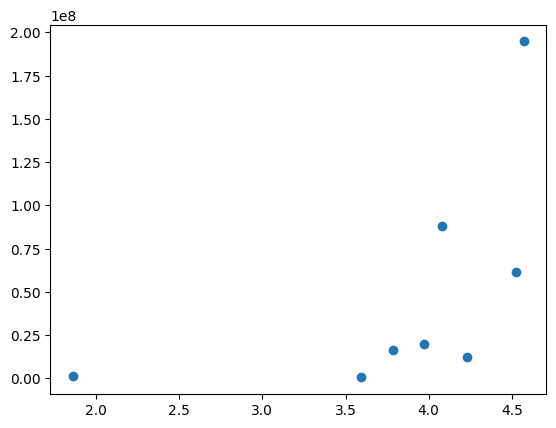

In [9]:
plt.scatter(a["risk"].values,a["return"].values)
plt.show()

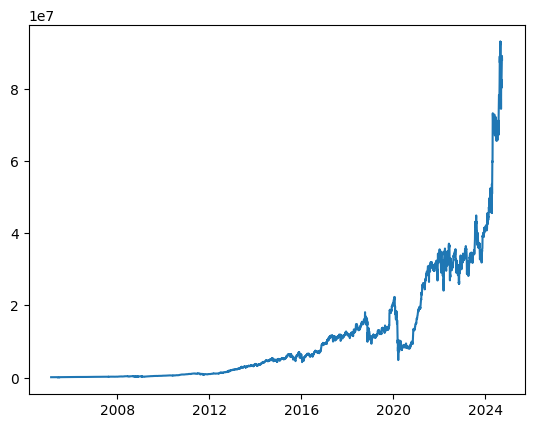

In [10]:
plt.plot(states["date"].values,states["pv"].values)
plt.show()